In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Turn csv into dataframe
parkinsons_df = pd.read_csv('parkinsons.csv')
print(parkinsons_df.columns)

# Preprocess data by checking for duplicates and missings
print(f'Duplicates: {parkinsons_df.duplicated().sum()}')
print(f'Missings: \n{parkinsons_df.isnull().sum()}')

# Since both duplicates and missings are 0, no need for adjustment

Index(['age', 'sex', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP',
       'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3',
       'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE',
       'DFA', 'PPE', 'target'],
      dtype='object')
Duplicates: 0
Missings: 
age              0
sex              0
test_time        0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
target           0
dtype: int64


c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Opti

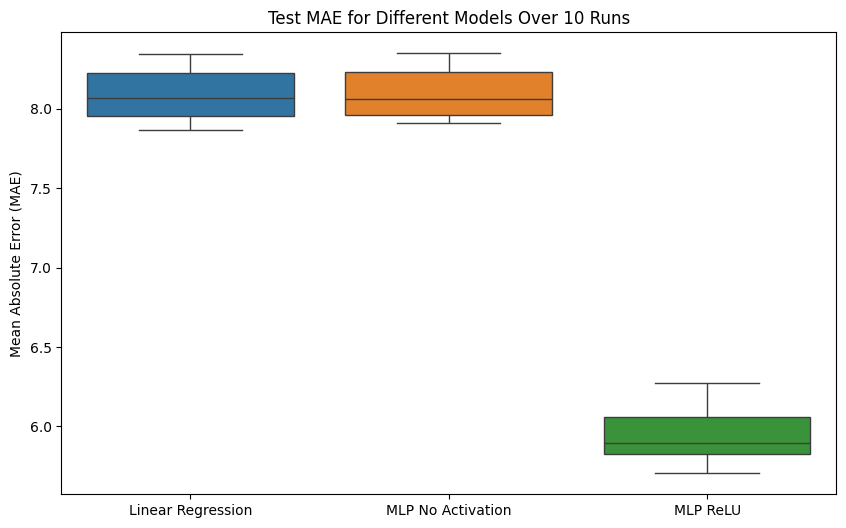

In [9]:
# Obtain features and labels
X = parkinsons_df.drop(columns='target')
y = parkinsons_df['target']

# Initialize lists to store MAE results
mae_linear = []
mae_mlp_no_activation = []
mae_mlp_relu = []

# Loop over 10 different train-test splits with random_state=i
for i in range(1, 11):
    # Split the data (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # 1 - Linear Regression
    lr_model = LinearRegression() # Declare
    lr_model.fit(X_train, y_train) # Fit
    y_pred_lr = lr_model.predict(X_test) # Predict
    mae_linear.append(mean_absolute_error(y_test, y_pred_lr)) # Error list
    
    # 2 - MLP Regressor with 2 hidden layers, 10 neurons, no activation f()
    mlp_no_activation = MLPRegressor(hidden_layer_sizes=(10, 10), activation='identity', random_state=0) # Declare
    mlp_no_activation.fit(X_train, y_train) # Fit
    y_pred_mlp_no_activation = mlp_no_activation.predict(X_test) # Predict
    mae_mlp_no_activation.append(mean_absolute_error(y_test, y_pred_mlp_no_activation)) # Error list
    
    # 3 - MLP Regressor with 2 hidden layers, 10 neurons, ReLU activation f()
    mlp_relu = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', random_state=0) # Declare
    mlp_relu.fit(X_train, y_train) # Fit
    y_pred_mlp_relu = mlp_relu.predict(X_test) # Predict
    mae_mlp_relu.append(mean_absolute_error(y_test, y_pred_mlp_relu)) # Error list


# We got the mae lists, now we can plot 'em 
mae_results_df = pd.DataFrame({
    'Linear Regression': mae_linear,
    'MLP No Activation': mae_mlp_no_activation,
    'MLP ReLU': mae_mlp_relu
})

# Create a boxplot of the test MAE for each model
plt.figure(figsize=(10, 6))
sns.boxplot(data=mae_results_df)
plt.title('Test MAE for Different Models Over 10 Runs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.show()

The MLP with no activation function behaves similarly to Linear Regression, as both can only model linear relationships and thus fail to capture non-linear behavior in the data. For example, without activation functions, an MLP with two hidden layers essentially performs a linear transformation, reducing to a single linear equation. In contrast, incorporating an activation function, such as ReLU, allows the MLP to learn complex, non-linear patterns, significantly improving its predictive performance, as can be shown from the figure, with MLP ReLU outperforming the two first models by 25%.

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

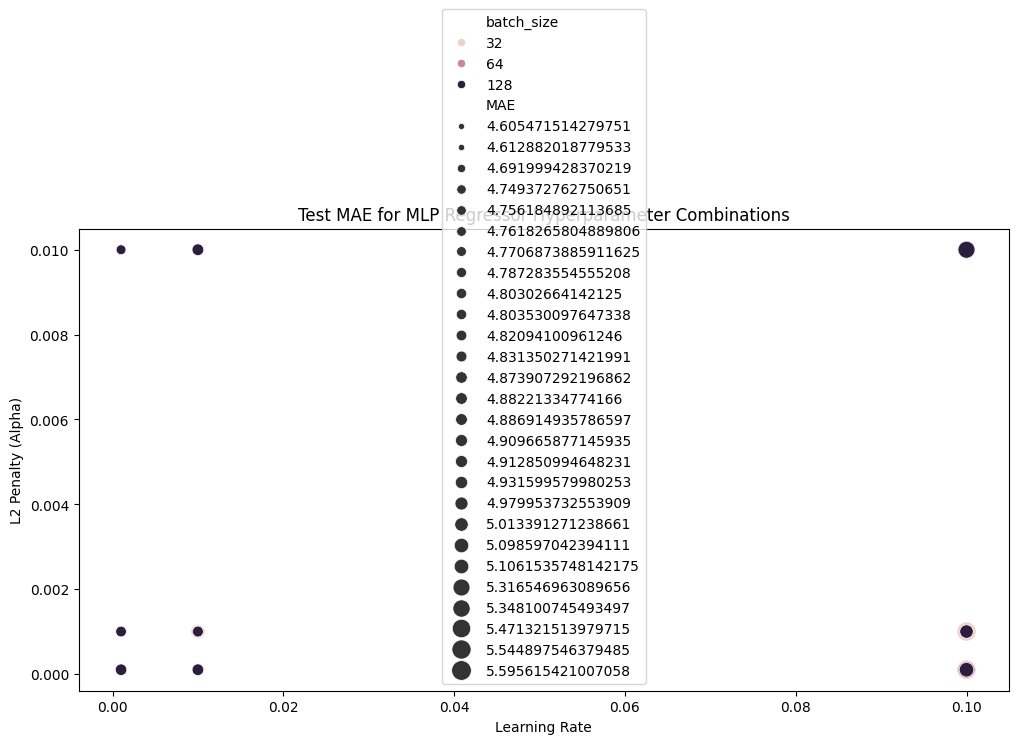

In [15]:
mlp = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=0)

# Hyperparameter grid we will search on
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty
    'learning_rate_init': [0.001, 0.01, 0.1],  # Learning rate
    'batch_size': [32, 64, 128]  # Batch size
}

# Run grid search
grid_search = GridSearchCV(mlp, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get data from grid search
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # we want positive MAE

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)

# Step 8: Extracting results for plotting
results = grid_search.cv_results_
scores = -results['mean_test_score']  # Convert to positive MAE
params = results['params']

# Create a DataFrame to hold the results for easier plotting
results_df = pd.DataFrame(params)
results_df['MAE'] = scores

# Step 9: Plotting the results
plt.figure(figsize=(12, 6))
sns.scatterplot(data=results_df, x='learning_rate_init', y='alpha', size='MAE', sizes=(20, 200), hue='batch_size', legend='full')
plt.title('Test MAE for MLP Regressor Hyperparameter Combinations')
plt.xlabel('Learning Rate')
plt.ylabel('L2 Penalty (Alpha)')
plt.colorbar(label='Batch Size')
plt.grid()
plt.show()

# Reporting the best combination
print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validated MAE: {best_score}")
print(f"Test MAE with Best Model: {test_mae}")